## 1) Count the jellybeans


In [2]:
#First, some imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import progressbar
%matplotlib inline

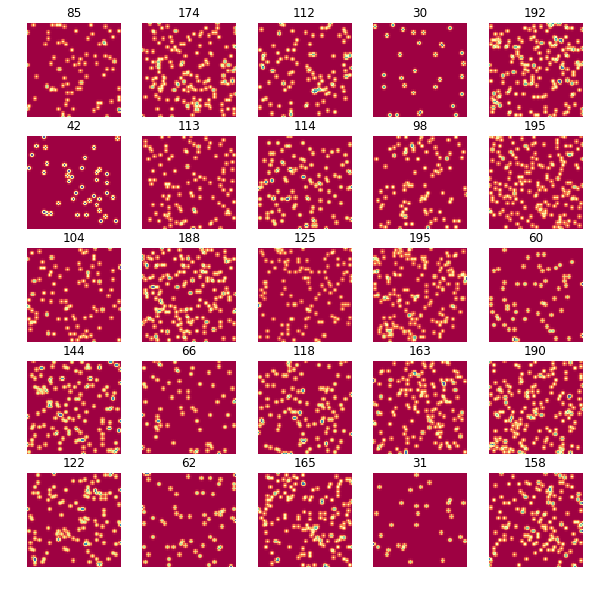

In [3]:
def make_data(N, L):
    image = np.zeros((N, L, L))
    labels = np.random.randint(10,200, (N))
    
    for i in range(N):
        for num_points in range(labels[i]):
            x = np.random.randint(0,L)
            y = np.random.randint(0,L)
            image[i,x,y] = 1.0
        image[i] = gaussian_filter(image[i],0.8)
    return image, labels.reshape((-1,1))


data, labels =  make_data(25,64)
fig, axs = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        axs[i][j].imshow(data[5*i+j], cmap='Spectral')
        axs[i][j].set_title('{0}'.format(labels[5*i+j][0]))
        axs[i][j].axis("off")

In [4]:
L = 64
f = 16
c = 4

In [5]:
def roll(in_, num, axis):
    D = tf.transpose(in_, perm=[axis, 1-axis])  #if axis=1, transpose first
    D = tf.concat([D[num:, :], D[0:num, :]], axis=0)
    return tf.transpose(D, perm=[axis, 1-axis]) #if axis=1, transpose back

def slice_(in_, x1, y1, w, h): 
    return in_[x1:x1+w, y1:y1+h]

def ednn_split(in_): 
    l = L
    #alternatively, a (probably better) way to get l is to do:
    #   l = in_.get_shape().as_list()[0]
   
    tiles = []
    for iTile in range(l/f):
        for jTile in range(l/f):
            #calculate the indices of the centre of this tile (i.e. the centre of the focus region)
            cot = (iTile*f + f/2, jTile*f + f/2) #centre of tile
            foc_centered = in_ 
            #shift the picture, wrapping the image around,
            #so that the focus is centered in the middle of the image
            foc_centered = roll(foc_centered, l/2-cot[0], 0)
            foc_centered = roll(foc_centered, l/2-cot[1], 1)
            #Finally slice away the excess image that we don't want to appear in this tile
            final = slice_(foc_centered, l/2-f/2-c, l/2-f/2-c, 2*c+f, 2*c+f)
            tiles.append(final)
            
    return tf.expand_dims(tiles, axis=3)


In [6]:
def NN(_in):
    tile_size = f + 2*c
    _in = tf.reshape(_in, (-1, tile_size**2))
    lay1 = tf.contrib.layers.fully_connected(_in, 64)
    lay2 = tf.contrib.layers.fully_connected(lay1, 128)
    lay3 = tf.contrib.layers.fully_connected(lay2, 128)
    lay4 = tf.contrib.layers.fully_connected(lay3, 1, activation_fn=None)
    return lay4

In [7]:
#data comes in a [ batch * L * L ] tensor, and labels a [ batch * 1] tensor
x = tf.placeholder(tf.float32, (None, L, L), name='input_image')
y = tf.placeholder(tf.float32, (None, 1))

#Then the EDNN-specific code:
print x.get_shape().as_list()
tiles = tf.map_fn(ednn_split, x, back_prop=False)
print tiles.get_shape().as_list()
tiles = tf.transpose(tiles, perm=[1,0,2,3,4])
print tiles.get_shape().as_list()
output = tf.map_fn(NN, tiles, back_prop=True)
print output.get_shape().as_list()
output = tf.transpose(output, perm=[1,0,2])
print output.get_shape().as_list()
predicted = tf.reduce_sum(output, axis=1)
print predicted.get_shape().as_list()


#define the loss function
loss = tf.reduce_mean(tf.square(y-predicted))

#create an optimizer, a training op, and an init op
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(loss)
init = tf.global_variables_initializer()

[None, 64, 64]
[None, 16, 24, 24, 1]
[16, None, 24, 24, 1]
[16, None, 1]
[None, 16, 1]
[None, 1]


In [8]:
sess = tf.InteractiveSession()
sess.run(init)

In [9]:
data, labels = make_data(2500, 64)
train_data = data[:2000]
test_data = data[2000:]
train_labels = labels[:2000]
test_labels = labels[2000:]

In [10]:
BATCH_SIZE = 100

bar = progressbar.ProgressBar()
for epoch in bar(range(50)):
    for batch in xrange(train_data.shape[0] / BATCH_SIZE):
        _, loss_val = sess.run([train_step, loss],
                               feed_dict={
                                    x: train_data[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE],
                                    y: labels[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE]
                                }
                              )


100% (50 of 50) |#########################| Elapsed Time: 0:01:27 Time: 0:01:27


In [11]:
prediction = sess.run(predicted, feed_dict={x: test_data})

/home/kmills/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


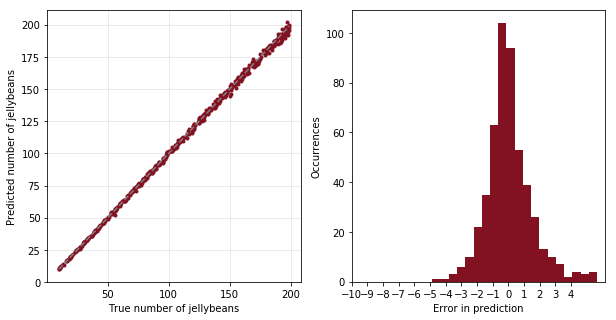

In [12]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(test_labels.flatten(), prediction.flatten(), '.', color='#821122')
ax[0].plot(np.arange(10,200), np.arange(10,200), '--', color='gray')
ax[0].set_xlabel("True number of jellybeans")
ax[0].set_ylabel("Predicted number of jellybeans")
ax[0].grid(alpha=0.3)
_ = ax[1].hist(test_labels.flatten()-prediction.flatten(), bins=20, color='#821122')
_ = ax[1].set_xticks(np.arange(-10,5))
ax[1].set_xlabel("Error in prediction")
ax[1].set_ylabel("Occurrences")
fig.show()
